# Analysis of 100 abstracts from development set

Tong Shu Li<br>
Created on: 2015-08-26<br>
Last updated: 2015-09-07

CrowdFlower jobs 771158 and 771159 were used to run the 100 abstracts from the development set in the same manner as the 500 abstracts from the evaluation set. Here we will look at how well the crowd did.

Job settings (sentence and abstract jobs respectively):

Parameter | Value
--- | ---
Job ID | #771159, #771158
Rows per page | 6
Judgements per row | 5
Payment per page | 12, 24 cents USD
Contributor level | 2
Minimum time per page | 18, 60 seconds
Minimum accuracy threshold | 70%
Number of test questions | 551, 228
Date of launch | 9:21 pm on 2015-08-25
Date of completion | 12:20 and 12:05 am on 2015-08-26
Total cost before bonuses | \$98.35, \$162.72 USD
Total cost after bonuses | \$98.35, \$162.72 USD

In [1]:
from collections import defaultdict
from IPython.display import Image
import copy
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle

In [2]:
matplotlib inline

In [3]:
from src.filter_data import filter_data
from src.data_model import *
from src.get_AUC_value import get_AUC_value
from src.F_score import *
from src.aggregate_results import *

In [4]:
from src.lingpipe.file_util import read_file

---

### Read the gold standard:

In [5]:
def read_gold_standard(dataset, file_format = "list"):
    assert dataset in ["training", "development"]
    assert file_format in ["list", "dict"]
    
    fname = "data/gold_standard/parsed_{0}_set_{1}.pickle".format(dataset, file_format)
    
    if os.path.exists(fname):
        print("Reading cached version of {0} set ({1})".format(dataset, file_format))
        
        with open(fname, "rb") as fin:
            data = pickle.load(fin)
    else:
        print("Parsing raw {0} file".format(dataset))
        data = parse_input("data/gold_standard".format(dataset),
                           "CDR_{0}Set.txt".format(dataset.capitalize()),
                           is_gold = True,
                           return_format = file_format,
                          fix_acronyms = False)
        
        with open(fname, "wb") as fout:
            pickle.dump(data, fout)
            
    return data

In [6]:
dev_gold = read_gold_standard("development", "dict")

Reading cached version of development set (dict)


In [7]:
def in_gold(row):
    pmid = int(row["pmid"])
    return int(dev_gold[pmid].has_relation(Relation(pmid, row["chemical_id"], row["disease_id"])))

### Read the tmChem/DNorm processed testset

In [8]:
dev_testset = parse_input("data/devset_100_test", "processed_CDR_devset.txt",
                         is_gold = False, return_format = "dict", fix_acronyms = True)

In [9]:
len(dev_testset.keys())

100

In [10]:
testset_pmids = set(dev_testset.keys())

In [11]:
testset_pmids

{33969,
 326460,
 803783,
 982002,
 1423339,
 1535072,
 1564236,
 1595783,
 1610717,
 1628552,
 1969772,
 2004015,
 2257294,
 2322844,
 2598570,
 2826064,
 2894433,
 2917114,
 3088349,
 3300918,
 3311455,
 3703509,
 3708922,
 3969369,
 3973521,
 6111982,
 6118280,
 6150641,
 6454943,
 6496797,
 6892185,
 7437994,
 7542793,
 7650771,
 7651879,
 7710775,
 7803371,
 7880714,
 8111719,
 8267029,
 8305357,
 8424298,
 8480959,
 8492347,
 8586822,
 8686832,
 8800187,
 9041081,
 9098464,
 9201797,
 9270571,
 9564988,
 9636837,
 9669632,
 9875685,
 10225068,
 10328196,
 10523326,
 10565806,
 10743694,
 10840460,
 10910842,
 11063349,
 11077455,
 11282081,
 11337188,
 11524350,
 11704023,
 11705128,
 11860278,
 11868798,
 11999899,
 12448656,
 12452237,
 12911170,
 15096016,
 15266215,
 15266362,
 15565293,
 15811908,
 15858223,
 15893386,
 16174948,
 16192988,
 16225977,
 16471092,
 16596970,
 17682013,
 18006530,
 18356633,
 18483878,
 18657397,
 19135948,
 19370593,
 19761039,
 20042557,
 204

### Look at how well the NER performed:

In [12]:
def ner_results(program_output, gold_data):
    TP = 0
    FP = 0
    num_concepts = 0
    
    pmids = program_output.keys()
    
    assert set(pmids).issubset(set(gold_data.keys()))
    
    for pmid, paper in program_output.items():
        gold_paper = gold_data[pmid]
        
        tp = 0
        fp = 0
        for prog_annot in paper.annotations:
            for gold_annot in gold_paper.annotations:
                if (prog_annot.start == gold_annot.start
                   and prog_annot.stop == gold_annot.stop):
                    
                    assert prog_annot.text == gold_annot.text
                    assert prog_annot.stype == gold_annot.stype
                

                    p = {v for v in prog_annot.uid if v.uid_type == "MESH"}
                    g = {v for v in gold_annot.uid if v.uid_type == "MESH"}

                    if p == g:
                        tp += 1
                    else:
                        fp += 1
                        
        num_concepts += len(gold_paper.annotations)
                
        TP += tp
        FP += fp
        
    recall = TP / num_concepts
    precision = TP / (TP + FP)
    
    f_score = 2 * precision * recall / (precision + recall)
    
    print("F score:", f_score)

    print("recall: {0}".format(recall))
    print("precision: {0}".format(precision))

    print("TP: {0}".format(TP))
    print("FP: {0}".format(FP))
    print("# of gold std annotations: {0}".format(num_concepts))

In [13]:
ner_results(dev_testset, dev_gold)

F score: 0.922762148337596
recall: 0.9069884364002011
precision: 0.9390942217595003
TP: 1804
FP: 117
# of gold std annotations: 1989


---

### Abstract-level task performance:

In [14]:
settings = {
    "loc": "data/crowdflower/results",
    "fname": "job_771158_full_with_untrusted.csv",
    "data_subset": "normal",
    "min_accuracy": 0.7,
    "max_accuracy": 1.0
}

abs_work_raw_data = filter_data(settings)

In [15]:
abs_work_raw_data.shape

(2700, 30)

In [16]:
abs_work_raw_data.head()

,_unit_id,_created_at,_golden,_id,_missed,_started_at,_tainted,_channel,_trust,_worker_id,...,disease_id,disease_name,form_abstract,form_title,old_cf_work_unit_id,original_job_id,pmid,uniq_id,verify_relationship_gold,verify_relationship_gold_reason
1381,778101077,8/26/2015 05:16:59,False,1721349910,NaN,8/26/2015 05:15:54,False,neodev,0.9091,27790533,...,MESH:D015746,"<span class=""disease"">abdominal pain</span>",<p>BACKGROUND: Irritable bowel syndrome is a c...,"Effects of <span class=""chemical"">cisapride</s...",NaN,NaN,9669632,bcv_devset_test_100_hard_0,NaN,NaN
1382,778101077,8/26/2015 05:18:02,False,1721350185,NaN,8/26/2015 05:16:52,False,clixsense,1.0000,17209680,...,MESH:D015746,"<span class=""disease"">abdominal pain</span>",<p>BACKGROUND: Irritable bowel syndrome is a c...,"Effects of <span class=""chemical"">cisapride</s...",NaN,NaN,9669632,bcv_devset_test_100_hard_0,NaN,NaN
1383,778101077,8/26/2015 05:21:32,False,1721351833,NaN,8/26/2015 05:16:52,False,neodev,0.8400,33870718,...,MESH:D015746,"<span class=""disease"">abdominal pain</span>",<p>BACKGROUND: Irritable bowel syndrome is a c...,"Effects of <span class=""chemical"">cisapride</s...",NaN,NaN,9669632,bcv_devset_test_100_hard_0,NaN,NaN
1384,778101077,8/26/2015 05:22:09,False,1721352160,NaN,8/26/2015 05:16:24,False,neodev,0.9231,33498392,...,MESH:D015746,"<span class=""disease"">abdominal pain</span>",<p>BACKGROUND: Irritable bowel syndrome is a c...,"Effects of <span class=""chemical"">cisapride</s...",NaN,NaN,9669632,bcv_devset_test_100_hard_0,NaN,NaN
1385,778101077,8/26/2015 05:23:38,False,1721353023,NaN,8/26/2015 05:16:40,False,clixsense,0.8000,17652709,...,MESH:D015746,"<span class=""disease"">abdominal pain</span>",<p>BACKGROUND: Irritable bowel syndrome is a c...,"Effects of <span class=""chemical"">cisapride</s...",NaN,NaN,9669632,bcv_devset_test_100_hard_0,NaN,NaN


In [17]:
abs_work_raw_data["_tainted"].value_counts()

False    2700
dtype: int64

In [18]:
abs_work_raw_data["verify_relationship"].value_counts(normalize = True)

no_relation    0.716667
yes_direct     0.283333
dtype: float64

In [19]:
def judgments(dataframe):
    votes = defaultdict(set)
    for uniq_id, group in dataframe.groupby("uniq_id"):
        votes[len(group["_worker_id"].unique())].add(uniq_id)

    for vote, units in votes.items():
        print("Judgements {0}, # of work units: {1}".format(vote, len(units)))

In [20]:
judgments(abs_work_raw_data)

Judgements 5, # of work units: 540


### Abstract-task result aggregation

In [21]:
abs_res = aggregate_results("uniq_id", "verify_relationship", abs_work_raw_data,
                        "positive_signal_only",
                        ["pmid", "_unit_id", "chemical_id", "disease_id"],
                        "yes_direct")

In [22]:
abs_res.shape

(1046, 9)

In [23]:
abs_res.head()

,uniq_id,verify_relationship,conf_score,num_votes,percent_agree,pmid,unit_id,chemical_id,disease_id
0,bcv_devset_test_100_hard_0,yes_direct,0.9091,1,0.203278,9669632,778101077,MESH:D020117,MESH:D015746
1,bcv_devset_test_100_hard_0,no_relation,3.5631,4,0.796722,9669632,778101077,MESH:D020117,MESH:D015746
0,bcv_devset_test_100_hard_1,yes_direct,1.9091,2,0.423201,9669632,778101078,MESH:D020117,MESH:D005767
1,bcv_devset_test_100_hard_1,no_relation,2.6020,3,0.576799,9669632,778101078,MESH:D020117,MESH:D005767
0,bcv_devset_test_100_hard_10,yes_direct,0.0000,0,0.000000,7880714,778101087,MESH:D002045,MESH:D006311


In [24]:
abs_res = abs_res.query("verify_relationship == 'yes_direct'")

In [25]:
abs_res.shape

(540, 9)

In [26]:
abs_res = abs_res.rename(columns = {"percent_agree":"norm_conf_score"})

In [27]:
abs_res.head()

,uniq_id,verify_relationship,conf_score,num_votes,norm_conf_score,pmid,unit_id,chemical_id,disease_id
0,bcv_devset_test_100_hard_0,yes_direct,0.9091,1,0.203278,9669632,778101077,MESH:D020117,MESH:D015746
0,bcv_devset_test_100_hard_1,yes_direct,1.9091,2,0.423201,9669632,778101078,MESH:D020117,MESH:D005767
0,bcv_devset_test_100_hard_10,yes_direct,0.0000,0,0.000000,7880714,778101087,MESH:D002045,MESH:D006311
0,bcv_devset_test_100_hard_100,yes_direct,0.0000,0,0.000000,19370593,778101177,MESH:D011372,MESH:D002318
0,bcv_devset_test_100_hard_101,yes_direct,0.0000,0,0.000000,19370593,778101178,MESH:D011372,MESH:D050723


---

### Sentence task performance:

In [28]:
settings = {
    "loc": "data/crowdflower/results",
    "fname": "job_771159_full_with_untrusted.csv",
    "data_subset": "normal",
    "min_accuracy": 0.7,
    "max_accuracy": 1.0
}

sent_raw_data = filter_data(settings)

In [29]:
sent_raw_data.shape

(3300, 30)

In [30]:
sent_raw_data["_tainted"].value_counts()

False    3245
True       55
dtype: int64

In [31]:
sent_raw_data = sent_raw_data.query("~_tainted")

In [32]:
sent_raw_data.shape

(3245, 30)

In [33]:
judgments(sent_raw_data)

Judgements 5, # of work units: 649


### Aggregate results at sentence level:

In [34]:
# take positive votes only, indirect is no
sent_lvl_res = aggregate_results("uniq_id", "verify_relationship",
                                 sent_raw_data, "positive_signal_only",
                                 ["pmid", "_unit_id", "chemical_id", "disease_id", "relation_pair_id", "sentence_id"],
                                 "yes_direct", {"yes_indirect" : "no_relation"})

In [35]:
sent_lvl_res.shape

(1159, 11)

In [36]:
sent_lvl_res.head()

,uniq_id,verify_relationship,conf_score,num_votes,percent_agree,pmid,unit_id,chemical_id,disease_id,relation_pair_id,sentence_id
0,bcv_devset_test_100_easy_0,yes_direct,1.7002,2,0.367611,9669632,778102225,MESH:D020117,MESH:D043183,9669632_MESH:D020117_MESH:D043183,9669632_0
1,bcv_devset_test_100_easy_0,no_relation,2.9248,3,0.632389,9669632,778102225,MESH:D020117,MESH:D043183,9669632_MESH:D020117_MESH:D043183,9669632_0
0,bcv_devset_test_100_easy_1,yes_direct,1.7002,2,0.378875,9669632,778102226,MESH:D020117,MESH:D043183,9669632_MESH:D020117_MESH:D043183,9669632_2
1,bcv_devset_test_100_easy_1,no_relation,2.7873,3,0.621125,9669632,778102226,MESH:D020117,MESH:D043183,9669632_MESH:D020117_MESH:D043183,9669632_2
0,bcv_devset_test_100_easy_10,yes_direct,1.8824,2,0.407808,9669632,778102235,MESH:D020117,MESH:D043183,9669632_MESH:D020117_MESH:D043183,9669632_9


In [37]:
sent_lvl_res = sent_lvl_res.query("verify_relationship == 'yes_direct'")

In [38]:
sent_lvl_res.shape

(649, 11)

In [39]:
sent_lvl_res.head()

,uniq_id,verify_relationship,conf_score,num_votes,percent_agree,pmid,unit_id,chemical_id,disease_id,relation_pair_id,sentence_id
0,bcv_devset_test_100_easy_0,yes_direct,1.7002,2,0.367611,9669632,778102225,MESH:D020117,MESH:D043183,9669632_MESH:D020117_MESH:D043183,9669632_0
0,bcv_devset_test_100_easy_1,yes_direct,1.7002,2,0.378875,9669632,778102226,MESH:D020117,MESH:D043183,9669632_MESH:D020117_MESH:D043183,9669632_2
0,bcv_devset_test_100_easy_10,yes_direct,1.8824,2,0.407808,9669632,778102235,MESH:D020117,MESH:D043183,9669632_MESH:D020117_MESH:D043183,9669632_9
0,bcv_devset_test_100_easy_100,yes_direct,4.2931,5,1.000000,17682013,778102325,MESH:D008727,MESH:D056784,17682013_MESH:D008727_MESH:D056784,17682013_6
0,bcv_devset_test_100_easy_101,yes_direct,3.6849,4,0.815929,17682013,778102326,MESH:D005472,MESH:D056784,17682013_MESH:D005472_MESH:D056784,17682013_6


### Aggregate at abstract level:

In [40]:
def aggregate_sentences(sentence_res):
    """
    Given the aggregated results at the individual work unit level,
    this function determines which sentence-bound drug-disease relationships
    are true at the abstract level.
    """
    res = defaultdict(list)
    for info, group in sentence_res.groupby(["pmid", "chemical_id", "disease_id"]):
        assert len(group["relation_pair_id"].unique()) == 1
        norm_conf_score_max = group["percent_agree"].max()
        
        res["pmid"].append(info[0])
        res["chemical_id"].append(info[1])
        res["disease_id"].append(info[2])
        
        res["num_votes"].append(group["num_votes"].max())
        res["norm_conf_score"].append(norm_conf_score_max)
        
        res["uniq_ids"].append("|".join(group["uniq_id"].unique()))
        res["unit_ids"].append("|".join(map(lambda x: str(int(x)), group["unit_id"].unique())))
        res["sentence_ids"].append("|".join(group["sentence_id"].unique()))
        
    return pd.DataFrame(res)

In [41]:
sent_perf_abs = aggregate_sentences(sent_lvl_res)

In [42]:
sent_perf_abs.shape

(426, 8)

In [43]:
sent_perf_abs.head()

,chemical_id,disease_id,norm_conf_score,num_votes,pmid,sentence_ids,uniq_ids,unit_ids
0,MESH:C017610,MESH:D010302,0.609304,3,33969,33969_1,bcv_devset_test_100_easy_279,778102504
1,MESH:C017610,MESH:D012559,0.000000,0,33969,33969_1,bcv_devset_test_100_easy_275,778102500
2,MESH:C084820,MESH:D001008,0.815284,4,33969,33969_3,bcv_devset_test_100_easy_285,778102510
3,MESH:C084820,MESH:D003866,0.225109,1,33969,33969_3,bcv_devset_test_100_easy_283,778102508
4,MESH:C084820,MESH:D004409,0.000000,0,33969,33969_3,bcv_devset_test_100_easy_284,778102509


In [44]:
with open("data/devset_100_test/devset_100_cid_relations.pickle", "rb") as fin:
    cid_relations = pickle.load(fin)

### Combine results from all three tracks together:

In [45]:
def get_data(dataframe, pmid):
    temp = dataframe.query("pmid == {0}".format(pmid))
    if temp.empty:
        return "empty"
    
    return temp[["pmid", "chemical_id", "disease_id", "norm_conf_score", "num_votes"]]

def get_final_res(sent_res, abs_res, datamodel):
    final_ans = []
    for pmid in testset_pmids:
        this_paper_rels = []
        
        # abstract relations
        temp = get_data(abs_res, pmid)
        if not isinstance(temp, str):
            temp["rel_origin"] = "abstract_task"
            this_paper_rels.append(temp)
            
        # sentence relations
        temp = get_data(sent_res, pmid)
        if not isinstance(temp, str):
            temp["rel_origin"] = "sentence_task"
            this_paper_rels.append(temp)
            
        things = defaultdict(list)
        paper_cid_rels = datamodel[pmid].poss_relations["CID"]
        if paper_cid_rels: # not empty
            for cid_relation in paper_cid_rels:
                for chem in cid_relation[0]:
                    for dise in cid_relation[1]:
                        things["pmid"].append(pmid)
                        things["chemical_id"].append(chem.flat_repr)
                        things["disease_id"].append(dise.flat_repr)
                        things["norm_conf_score"].append(1)
                        things["num_votes"].append(5)
                        things["rel_origin"].append("cid_relation")
                
            this_paper_rels.append(pd.DataFrame(things))
            
        if len(this_paper_rels) > 0:
            # some papers have no detectable relations (eg, pmid 250)
            final_ans.append(pd.concat(this_paper_rels))
        
    return pd.concat(final_ans)

In [46]:
# check stored CID relations are the same as the parsed dataset's
for pmid, paper in dev_testset.items():
    assert paper.poss_relations["CID"] == cid_relations[pmid]

In [47]:
final_res = get_final_res(sent_perf_abs, abs_res, dev_testset)

In [48]:
final_res

,chemical_id,disease_id,norm_conf_score,num_votes,pmid,rel_origin
0,MESH:D020117,MESH:D015746,0.203278,1,9669632,abstract_task
0,MESH:D020117,MESH:D005767,0.423201,2,9669632,abstract_task
212,MESH:D020117,MESH:D003248,0.212550,1,9669632,sentence_task
213,MESH:D020117,MESH:D003967,0.377915,2,9669632,sentence_task
214,MESH:D020117,MESH:D010146,1.000000,5,9669632,sentence_task
215,MESH:D020117,MESH:D043183,0.568115,3,9669632,sentence_task
0,MESH:C117268,MESH:D003875,0.577846,3,20466178,abstract_task
0,MESH:C117268,MESH:D012393,0.792744,4,20466178,abstract_task
0,MESH:D016559,MESH:D013684,1.000000,5,20466178,abstract_task
0,MESH:C117268,MESH:D013684,1.000000,5,20466178,abstract_task


In [49]:
final_res["in_gold"] = final_res.loc[:, ["pmid", "chemical_id", "disease_id"]].apply(in_gold, axis = 1)

In [50]:
final_res.head()

,chemical_id,disease_id,norm_conf_score,num_votes,pmid,rel_origin,in_gold
0,MESH:D020117,MESH:D015746,0.203278,1,9669632,abstract_task,1
0,MESH:D020117,MESH:D005767,0.423201,2,9669632,abstract_task,0
212,MESH:D020117,MESH:D003248,0.212550,1,9669632,sentence_task,0
213,MESH:D020117,MESH:D003967,0.377915,2,9669632,sentence_task,0
214,MESH:D020117,MESH:D010146,1.000000,5,9669632,sentence_task,0


### Performance using unofficial evaluation metric:

In [51]:
max_F_score("norm_conf_score", "in_gold", final_res)

F_score      0.637209
precision    0.545817
recall       0.765363
threshold    0.789366
Name: 369, dtype: float64

In [52]:
max_F_score("num_votes", "in_gold", final_res)

F_score      0.625571
precision    0.528958
recall       0.765363
threshold    4.000000
Name: 4, dtype: float64

### ROC analysis:

In [53]:
fname = "data/roc/dev_testset_100_abstracts_total_res.png"
title = "ROC for 100 development set abstracts with indirect votes meaning no, norm_conf_score"
get_AUC_value(final_res, "norm_conf_score", "in_gold", fname, title)

0.8678053251207944

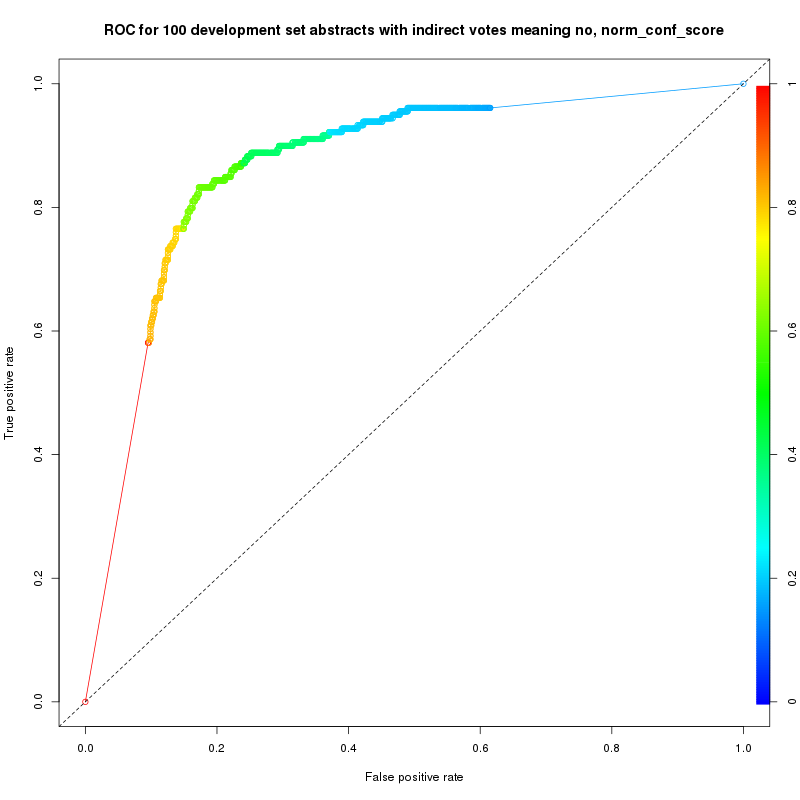

In [54]:
Image(fname)

In [55]:
fname = "data/roc/dev_testset_100_abstracts_total_res_votes.png"
title = "ROC for 100 development set abstracts with indirect votes meaning no, num_votes"
get_AUC_value(final_res, "num_votes", "in_gold", fname, title)

0.8633138128323146

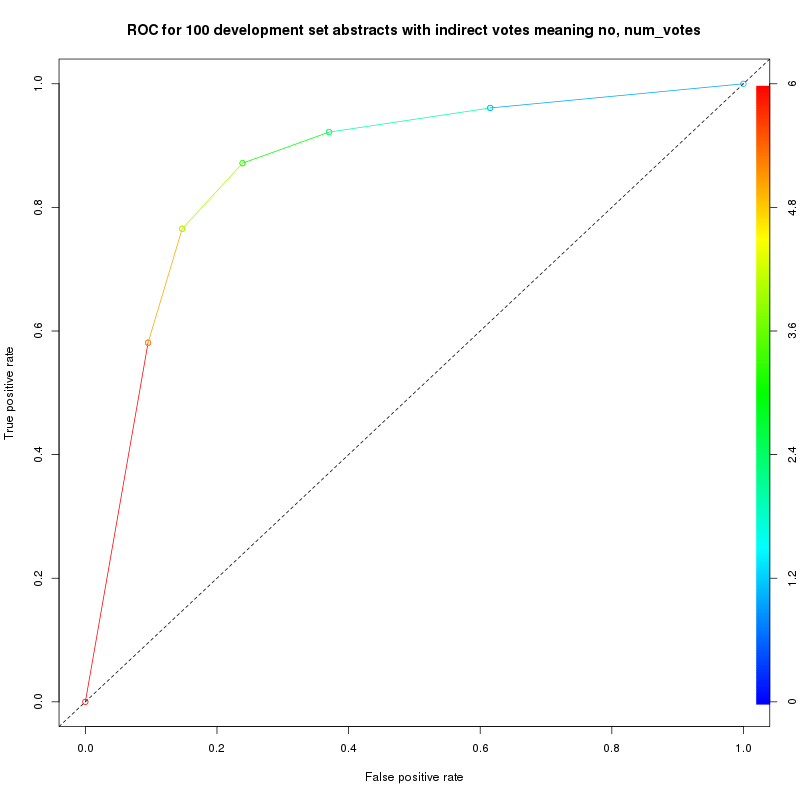

In [56]:
Image(fname)

In [57]:
def plot_results(score_column, class_column, dataframe):
    res = all_F_scores(score_column, class_column, dataframe)
    res = res.sort("threshold")
    
    graph = res.plot(x = "threshold", figsize = (7, 7))
    graph.set_ylim((0, 1.1))

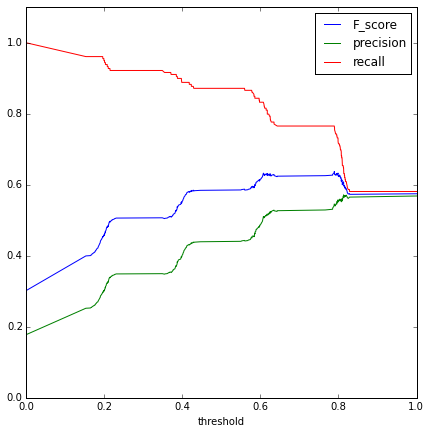

In [58]:
plot_results("norm_conf_score", "in_gold", final_res)

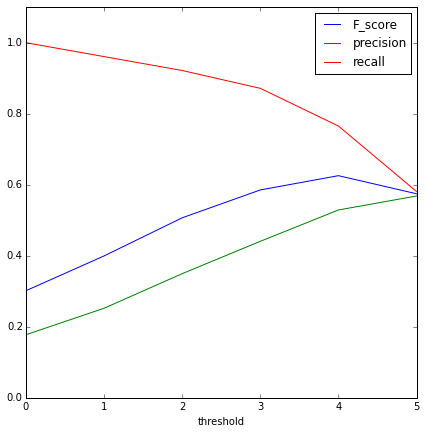

In [60]:
plot_results("num_votes", "in_gold", final_res)

This isn't correct, since the recall should not be 1.0 due to the NER step.

# Evaluation using the official method

In [60]:
def simple_repr(id_set):
    assert len(id_set) == 1
    temp = sorted(list(id_set))
    return "|".join(temp)

def get_gold_rels(pmid_set, gold_std):
    res = set()
    for pmid in pmid_set:
        paper = gold_std[pmid]
        for rel in paper.gold_relations:
            rep = "{0}#{1}+{2}".format(pmid, simple_repr(rel.chemical_id), simple_repr(rel.disease_id))
            res |= set([rep])
    
    return res

In [61]:
gold_relations = get_gold_rels(dev_testset, dev_gold)

In [62]:
len(gold_relations)

207

In [63]:
gold_relations

{'10225068#MESH:D008012+MESH:D011128',
 '10328196#MESH:D020123+MESH:D019559',
 '10523326#MESH:D007854+MESH:D006973',
 '10565806#MESH:C076029+MESH:D001714',
 '10743694#MESH:D016559+MESH:D000743',
 '10743694#MESH:D016559+MESH:D003922',
 '10743694#MESH:D016559+MESH:D005767',
 '10743694#MESH:D016559+MESH:D007674',
 '10743694#MESH:D016559+MESH:D008232',
 '10743694#MESH:D016559+MESH:D009202',
 '10743694#MESH:D016559+MESH:D011537',
 '10743694#MESH:D016559+MESH:D020258',
 '10743694#MESH:D016559+MESH:D056486',
 '10840460#MESH:D000171+MESH:D010146',
 '10840460#MESH:D003520+MESH:D003556',
 '10840460#MESH:D003520+MESH:D010146',
 '10910842#MESH:D011239+MESH:D009133',
 '10910842#MESH:D011239+MESH:D018908',
 '11063349#MESH:D016559+MESH:D007674',
 '11063349#MESH:D016572+MESH:D007674',
 '11077455#MESH:D020888+MESH:D014786',
 '11282081#MESH:D014700+MESH:D001281',
 '11337188#MESH:D000305+MESH:D018366',
 '11337188#MESH:D000305+MESH:D051437',
 '11337188#MESH:D010068+MESH:D018366',
 '11337188#MESH:D010068+M

In [64]:
# want to get one big df with all gold relations for use in ROC

def roc_dataframe(final_res):
    temp = defaultdict(list)
    
    # split up the crowd results with complexed ids
    for idx, row in final_res.iterrows():
        pmid = int(row["pmid"])
        chem_ids = row["chemical_id"].split("|")
        dise_ids = row["disease_id"].split("|")

        cols = ["norm_conf_score", "num_votes", "pmid", "rel_origin"]

        for chem in chem_ids:
            for dise in dise_ids:
                temp["chemical_id"].append(chem)
                temp["disease_id"].append(dise)

                for val in cols:
                    temp[val].append(row[val])

                text = "{0}#{1}+{2}".format(pmid, chem, dise)
                
                temp["in_gold"].append(int(text in gold_relations))
                temp["text"].append(text)
                
    useful = pd.DataFrame(temp)
                
    # add any missing gold relations
    for rel in gold_relations:
        q = useful.query("text == '{0}'".format(rel))
        if q.empty:
            pmid = int(rel.split("#")[0])
            chem, dise = rel.split("#")[1].split("+")
            
            temp["pmid"].append(pmid)
            temp["chemical_id"].append(chem)
            temp["disease_id"].append(dise)
            
            temp["norm_conf_score"].append(0)
            temp["num_votes"].append(0)
            temp["rel_origin"].append("gold_std")
            temp["in_gold"].append(1)
            temp["text"].append(rel)
            

    return pd.DataFrame(temp)

In [65]:
roc_df = roc_dataframe(final_res)

In [66]:
roc_df.head()

,chemical_id,disease_id,in_gold,norm_conf_score,num_votes,pmid,rel_origin,text
0,MESH:D020117,MESH:D015746,1,0.203278,1,9669632,abstract_task,9669632#MESH:D020117+MESH:D015746
1,MESH:D020117,MESH:D005767,0,0.423201,2,9669632,abstract_task,9669632#MESH:D020117+MESH:D005767
2,MESH:D020117,MESH:D003248,0,0.212550,1,9669632,sentence_task,9669632#MESH:D020117+MESH:D003248
3,MESH:D020117,MESH:D003967,0,0.377915,2,9669632,sentence_task,9669632#MESH:D020117+MESH:D003967
4,MESH:D020117,MESH:D010146,0,1.000000,5,9669632,sentence_task,9669632#MESH:D020117+MESH:D010146


In [67]:
roc_df["in_gold"].sum()

207

In [68]:
fname = "data/roc/dev_testset_100_abstracts_official_method_total_res_votes.png"
title = "ROC for 100 abstracts from the development set thresholded by number of votes"
get_AUC_value(roc_df, "num_votes", "in_gold", fname, title)

0.7725814963666627

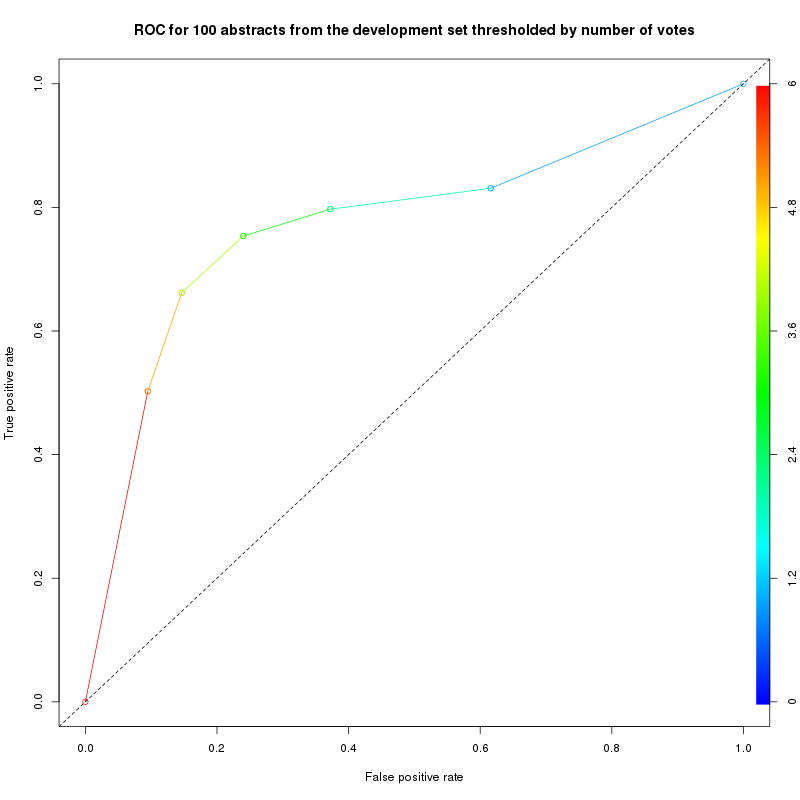

In [69]:
Image(fname)

In [70]:
def formater(s):
    if is_MeSH_id(s):
        return "MESH:{0}".format(s)
    
    assert s.startswith("MESH"), s
    assert is_MeSH_id(s.split(":")[1]), s
    return s

def get_list(s):
    return [formater(v) for v in s.split("|")]
    
def new_F_score(score_column, gold_rel_set, dataframe):
    EPSILON = 0.0000001
    
    res = defaultdict(list)
    for threshold in dataframe[score_column].unique():
        sub = dataframe.query("{0} > {1} or -{2} <= {0} - {1} <= {2}".format(score_column, threshold, EPSILON))
        
        # grab the relation ids we guessed
        guess_set = set()
        for idx, row in sub.iterrows():
            chem_id = row["chemical_id"]
            dise_id = row["disease_id"]
            pmid = row["pmid"]
            
            chem_id = get_list(chem_id)
            dise_id = get_list(dise_id)
            
            temp = []
            for cid in chem_id:
                for did in dise_id:
                    temp.append("{0}#{1}+{2}".format(int(pmid), cid, did))
                    
            guess_set |= set(temp)                    
                
        tp = len(gold_rel_set & guess_set)
        fp = len(guess_set - gold_rel_set)
        fn = len(gold_rel_set - guess_set)
        
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f_score = F_score(precision, recall)
        
        res["recall"].append(recall)
        res["precision"].append(precision)
        res["threshold"].append(threshold)
        res["F_score"].append(f_score)
        
    return pd.DataFrame(res)

In [71]:
final_res["chemical_id"].map(len).value_counts()

12    1004
25       4
dtype: int64

In [72]:
def expand_dataframe(final_res):
    temp = defaultdict(list)
    
    # split up the crowd results with complexed ids
    for idx, row in final_res.iterrows():
        pmid = int(row["pmid"])
        chem_ids = row["chemical_id"].split("|")
        dise_ids = row["disease_id"].split("|")

        cols = ["norm_conf_score", "num_votes", "pmid", "rel_origin"]

        for chem in chem_ids:
            for dise in dise_ids:
                temp["chemical_id"].append(chem)
                temp["disease_id"].append(dise)

                for val in cols:
                    temp[val].append(row[val])

                text = "{0}#{1}+{2}".format(pmid, chem, dise)
                
                temp["in_gold"].append(int(text in gold_relations))
                temp["text"].append(text)
                
    return pd.DataFrame(temp)

In [73]:
expanded_res = expand_dataframe(final_res)

In [74]:
expanded_res.shape

(1012, 8)

### Performance using official evaluation metric:

In [75]:
official_res = new_F_score("norm_conf_score", gold_relations, expanded_res)

In [76]:
official_res.sort("F_score", ascending = False).head()

,F_score,precision,recall,threshold
369,0.598253,0.545817,0.661836,0.789366
38,0.597194,0.510274,0.719807,0.607823
166,0.596950,0.543651,0.661836,0.789359
361,0.596000,0.508532,0.719807,0.607743
23,0.595652,0.541502,0.661836,0.788715


In [77]:
official_res_vote = new_F_score("num_votes", gold_relations, expanded_res)

In [78]:
official_res_vote.sort("F_score", ascending = False)

,F_score,precision,recall,threshold
4,0.587983,0.528958,0.661836,4
3,0.554174,0.438202,0.753623,3
2,0.533333,0.568306,0.502415,5
1,0.483871,0.347368,0.797101,2
0,0.385650,0.251095,0.830918,1
5,0.293683,0.176877,0.864734,0


In [79]:
official_res_vote.sort("threshold", ascending = False)

,F_score,precision,recall,threshold
2,0.533333,0.568306,0.502415,5
4,0.587983,0.528958,0.661836,4
3,0.554174,0.438202,0.753623,3
1,0.483871,0.347368,0.797101,2
0,0.385650,0.251095,0.830918,1
5,0.293683,0.176877,0.864734,0


In [80]:
def plot_it(res, title, xlabel):
    res = res.sort("threshold")

    graph = res.plot(x = "threshold", figsize = (7, 7),
                    title = title)
    graph.set_ylim((0, 1.1))
    graph.set_xlabel(xlabel)

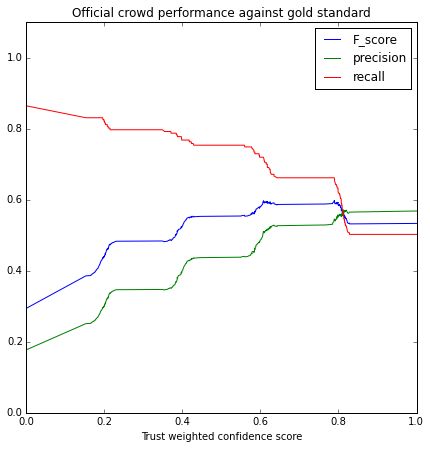

In [81]:
plot_it(official_res, "Official crowd performance against gold standard", "Trust weighted confidence score")

In [82]:
import matplotlib

In [83]:
matplotlib.rcParams.update({'font.size': 12})

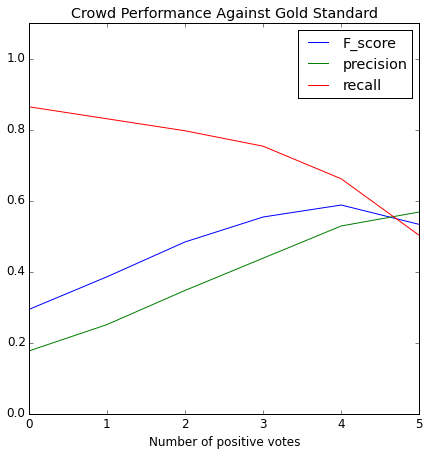

In [84]:
plot_it(official_res_vote, "Crowd Performance Against Gold Standard", "Number of positive votes")

In [118]:
def bar_plot(res, title, xlabel):
    res = res.sort("threshold")
    matplotlib.rcParams.update({'font.size': 12})
    graph = res.plot(kind = "bar", x = "threshold", figsize = (7, 7),
                    title = title)
    graph.set_ylim((0, 1.1))
    graph.set_xlabel(xlabel)

In [142]:
def bigger_plot(res, title, xlabel, fontsize, figsize, fname):
    res = res.sort("threshold")
    matplotlib.rcParams.update({'font.size': fontsize})

    graph = res.plot(x = "threshold", figsize = figsize,
                     linewidth = 5,
                    title = title)
    graph.set_ylim((0, 1.1))
    graph.set_xlabel(xlabel)
    
    plt.savefig(fname, bbox_inches = "tight")

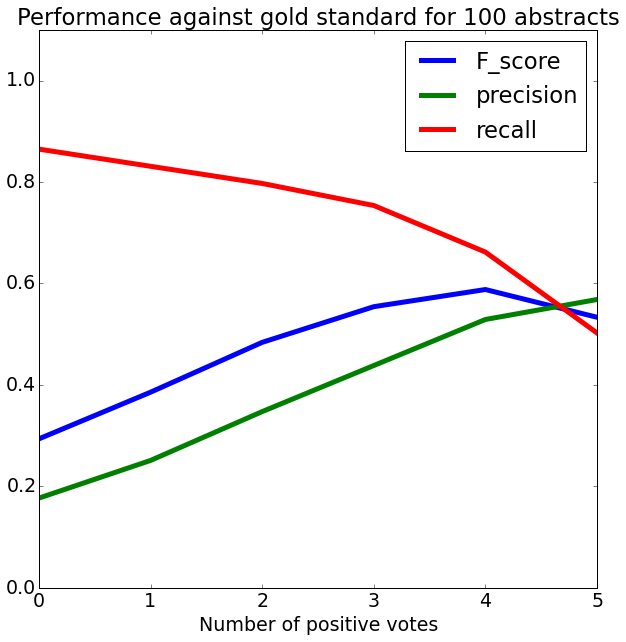

In [158]:
bigger_plot(official_res_vote, "Performance against gold standard for 100 abstracts", "Number of positive votes",
        19, (10, 10), "data/perf_full_presentation.png")

In [159]:
official_res_vote

,F_score,precision,recall,threshold
0,0.385650,0.251095,0.830918,1
1,0.483871,0.347368,0.797101,2
2,0.533333,0.568306,0.502415,5
3,0.554174,0.438202,0.753623,3
4,0.587983,0.528958,0.661836,4
5,0.293683,0.176877,0.864734,0


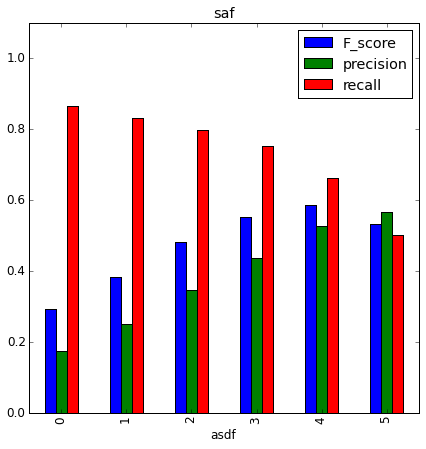

In [119]:
bar_plot(official_res_vote, "saf", "asdf")

In [85]:
def big_plot(res, title, xlabel, fontsize, figsize, fname):
    res = res.sort("threshold")
    matplotlib.rcParams.update({'font.size': fontsize})

    graph = res.plot(x = "threshold", figsize = figsize,
                     linewidth = 10,
                    title = title)
    graph.set_ylim((0, 1.1))
    graph.set_xlabel(xlabel)
    
    plt.savefig(fname, bbox_inches = "tight")

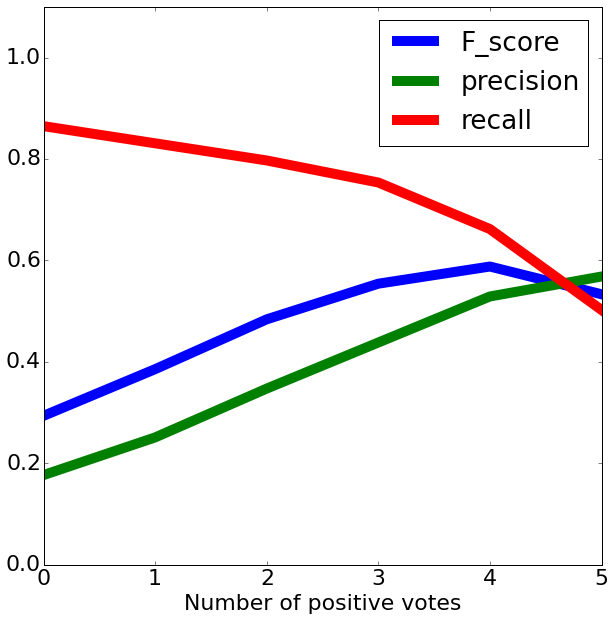

In [86]:
big_plot(official_res_vote, "", "Number of positive votes",
        22, (10, 10), "data/perf_full.eps")

---

## Analysis of performance with NER step excluded (impossible relations removed)

Due to the NER step, some concept annotations will be missed or mismapped. When this happens, any relation which uses these concepts will automatically be counted as false positives or false negatives. To look at crowd performance on the relation extraction task only, we need to remove these relations.

However this seems like a more convoluted way of measuring performance instead of running the job over again, but using the gold standard annotations (which we were doing anyways). Hope the reviewers don't catch this..

### We need to split the ids for the output

In [87]:
def has_concept(paper, concept_id):
    """Does this paper have this concept id?"""
    concepts = set()
    for annot in paper.annotations:
        concepts |= annot.uid
        
    concept = Ontology_ID(concept_id)
#     print(concepts)
    return concept in concepts

In [88]:
expanded_res.shape

(1012, 8)

In [89]:
expanded_res["rel_origin"].value_counts(normalize = True)

abstract_task    0.535573
sentence_task    0.422925
cid_relation     0.041502
dtype: float64

In [90]:
expanded_res["rel_origin"].value_counts()

abstract_task    542
sentence_task    428
cid_relation      42
dtype: int64

In [91]:
len(gold_relations)

207

### Performance for each track

In [92]:
temp = expanded_res.query("rel_origin == 'cid_relation'")
new_F_score("num_votes", gold_relations, temp)

,F_score,precision,recall,threshold
0,0.232932,0.690476,0.140097,5


In [93]:
temp = expanded_res.query("rel_origin == 'sentence_task'")
sent_perf = new_F_score("num_votes", gold_relations, temp).sort("threshold")

In [94]:
sent_perf

,F_score,precision,recall,threshold
5,0.314961,0.233645,0.483092,0
0,0.373541,0.312704,0.463768,1
1,0.435374,0.410256,0.463768,2
3,0.457584,0.489011,0.429952,3
4,0.442577,0.526667,0.381643,4
2,0.394904,0.579439,0.299517,5


In [95]:
temp = expanded_res.query("rel_origin == 'abstract_task'")
abs_perf = new_F_score("num_votes", gold_relations, temp).sort("threshold")

In [96]:
abs_perf

,F_score,precision,recall,threshold
5,0.133511,0.092251,0.241546,0
0,0.173112,0.139881,0.227053,1
1,0.197044,0.201005,0.193237,2
2,0.224189,0.287879,0.183575,3
3,0.211679,0.432836,0.140097,4
4,0.107884,0.382353,0.062802,5


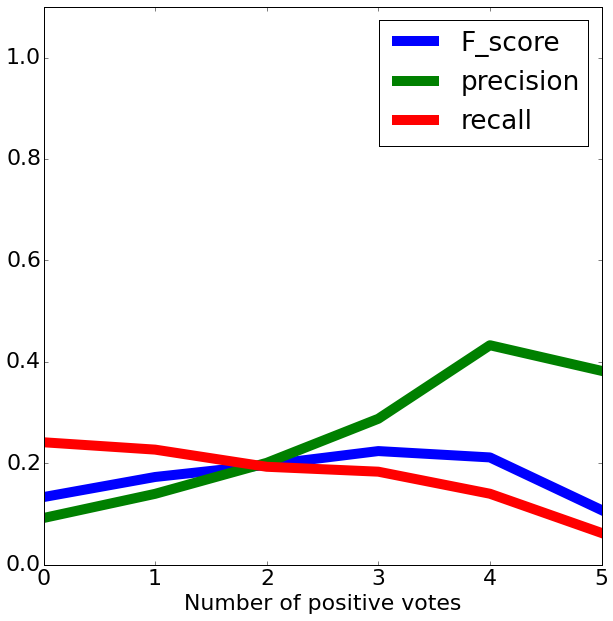

In [97]:
big_plot(abs_perf, "", "Number of positive votes",
        22, (10, 10), "data/abs_perf_only.eps")

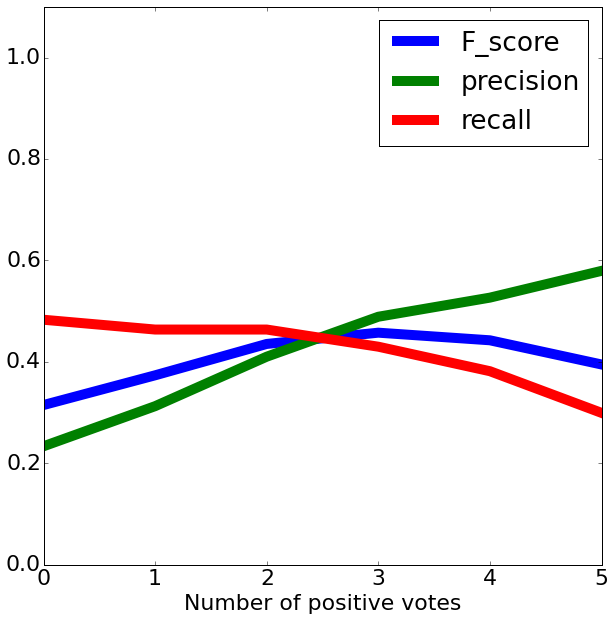

In [98]:
big_plot(sent_perf, "", "Number of positive votes",
        22, (10, 10), "data/sent_perf_only.eps")

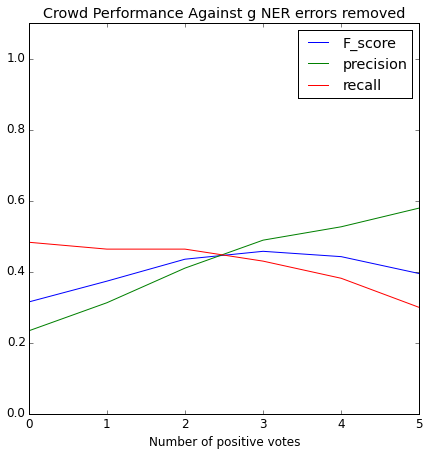

In [99]:
matplotlib.rcParams.update({'font.size': 12})
title = "Crowd Performance Against g NER errors removed"

plot_it(sent_perf, title, "Number of positive votes")

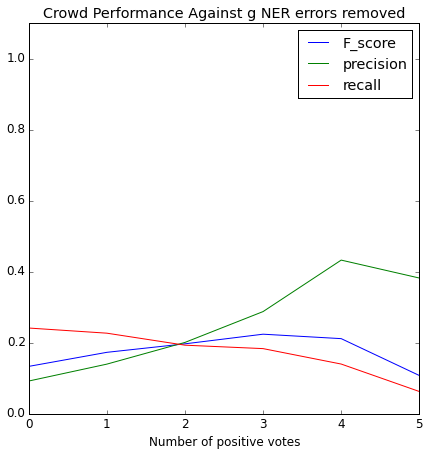

In [100]:
matplotlib.rcParams.update({'font.size': 12})
title = "Crowd Performance Against g NER errors removed"

plot_it(abs_perf, title, "Number of positive votes")

Error analysis

PMID | Chemical | disease | Origin | Discussion
--- | ---
3088349 | D016627 | D001927 | CID | Id mismatch. Gold has no id for "substantia nigra lesion", whereas we mapped it to "D001927", "brain diseases". Not a mistake in the regex. Missing id in gold.
9270571 | D015632 | D010302 | CID | For "MPTP-induced parkinsonism", gold mapped "parkinsonism" to D020734 but we mapped it to D010300. Not a regex mistake. ID mismatch.
8267029 | D010396 | C538458 | CID | Gold used "glomerulonephritis" instead of "rapidly progressive glomerulonephritis" with "penicillamine". Term was not a disease according to the gold. ID mismatch.
10910842 | D011239 | D009135 | CID | Mismatch in IDs for "muscle dysfunction". We used "D009135" instead of D018908. ID mismatch.
8111719 | D007096 | D020258 | CID | "ifosfamide-induced neurotoxicity". Gold used hallucination instead of the more general neurotoxicity. Not a regex error. Hierarchy error.
18657397 | D010406 | D004827 | CID | "penicillin induced epileptiform activity". Gold used "penicillin G potassium" instead of "penicillin". ID mismatch
9041081 | D013256 | D009798 | CID | "steroid induced elevated intraocular pressure". Gold used "corticosteriod" instead of "steroid". Hierarchy mismatch.
20533999 | D008694 | D064420, D009461 | CID | "methamphetamine induced (toxicity and dopaminergic deficits)". Gold only used neurotoxicity, which is a more specific form of toxicity. Hierarchy mismatch
1595783 | D000638 | D008171 | CID | "amiodarone-induced pulmonary toxicity" Gold does not include this relation, preferring hypersensitivity pneumonitis instead.
12452237 | D013390 | D063806 | CID | "succinylcholine induced myalgia". Gold contains "succinylcholine induced postoperative myalgia", but not regular "myalgia" (different identifiers).
16192988 | D008694 | D006948 | CID | "meth-induced hyperactivity". This relation was never included in the gold, but the pattern was found correctly.
3708922 | D016572 | D064420 | CID | "CSA induced toxicity". Gold only contains "CSA induced nephrotoxicity". However, it seems like Gentamicin should also be related to nephrotoxicity since "Gentamicin increased CSA nephrotoxicity". NER never found "nephrotoxicity" in the same sentence as gentamicin (but annotated renal toxicity with the same ID), and therefore we missed this relation.






Error analysis: sentences in gold but crowd said no (<= 1 positive vote)

PMID | Chemical | Disease | Origin | Discussion
--- | ---
7710775 | D008315 | D002545 | sentence | "malondialdehyde and cerebral ischemia". IDs were successfully mapped. The text states that cerebral ischemia in a rat model was caused by clamping the carotid artery. They then sampled the blood for malondialdehyde and found that it increased in concentration starting 5 min after ischemia. The gold standard lists malondialdehyde as causing ischemia, whereas the abstract suggests that the relation is more of a correlation. Seems like gold is wrong here.. Crowd said 0/5 true, only saw the title.
20042557 | D015742 | D003693, D011183 | sentence | "propofol and delirium, postoperative delirium". We missed 2 gold relations. The gold is correct in stating that propofol leads to postoperative delirium when used in high concentrations. In the last sentence, where propofol and postoperative delirium is mentioned together, the sentence says using "light propofol sedation" decreases the prevalance of "postoperative delirium" compared with deep sedation (high propofol concentration). The crowd is not wrong here in saying that the sentence doesn't support a CID relation. The task formulation removed the larger context. Gold is right.
10840460 | D003520 | D010146 | sentence | "cyclophosphamide and painful syndromes". Crowd only saw the concluding sentence, and therefore had no information about what the "painful syndromes" referred to. If anything this is bad form on the gold's part, because the individual syndromes should have been annotated, and not "painful syndromes" in general.




Error analysis: sentences not in gold but crowd said yes (5/5 positive votes)

PMID | Chemical | Disease | Origin | conclusion | Discussion
--- | ---
982002 | D012293 | D051437 | sentence | hierarchy error | "rifampicin and renal failure". Gold only contained "acute renal failure". Hierarchy problem. Can be fixed using MeSH (high overlap)
1423339 | D011433 | D000544, D064420 | sentence | ner error | propranolol and Alzheimer, toxicity. Gold only contained "amnestic syndrome". Alzheimer is a NER error, since it should be "Alzheimer-like subacute dementia". The toxicity one is more vague, since the text says "propranolol toxicity".
1535072 | D012701 | D020018 | sentence | ner error | "serotonin and sexual side effects". This is a result of poor NER highlighting. Serotonin is a chemical, but it was always used as "serotonin reuptake blockers", which is a completely different class of drug. The gold suffered from this too, since it annotated "serotonin" as a chemical many times instead of "serotonin reuptake blockers". We have previously seen that crowd performs very poorly at distinguishing NER errors when they are told the highlighted concept is a chemical/disease. Not much we could have done here without doing extraction de novo.
1535072 | D015016 | D001008 | sentence | gold missing relation | "yohimbine and anxiety". Abstract says "Side effects of yohimbine included excessive sweating, increased anxiety, and a wound-up feeling in some patients." Seems like gold is missing some relations? NER also never picked up "excessive sweating" or "wound-up feeling".
1628552 | D002738 | D014786 | sentence | ner error | "chloroquine and deterioration of vision". NER error. Gold annotated deterioration of vision as D015354, and has the relation.
1628552 | D002738 | D006327 | sentence | gold missing relation? | "chloroquine and heart block". Correct ids, but relation missing from gold. Title says "Chloroquine related complete heart block with blindness: case report". Gold error?
2257294 | D014529 | D064420 | sentence | gold missing relation | "uridine and toxicity". Text says "Because of the clinical toxicities associated with chronic Urd administration". Seems like gold is wrong?
3088349 | D016627 | D009069 | sentence | crowd likely wrong | "6-OHDA and contralateral rotation". Ids match but gold is missing relation. Seems like this should have been yes_indirect instead of yes_direct.



In [ ]:
expanded_res.query

In [101]:
expanded_res.head()

,chemical_id,disease_id,in_gold,norm_conf_score,num_votes,pmid,rel_origin,text
0,MESH:D020117,MESH:D015746,1,0.203278,1,9669632,abstract_task,9669632#MESH:D020117+MESH:D015746
1,MESH:D020117,MESH:D005767,0,0.423201,2,9669632,abstract_task,9669632#MESH:D020117+MESH:D005767
2,MESH:D020117,MESH:D003248,0,0.212550,1,9669632,sentence_task,9669632#MESH:D020117+MESH:D003248
3,MESH:D020117,MESH:D003967,0,0.377915,2,9669632,sentence_task,9669632#MESH:D020117+MESH:D003967
4,MESH:D020117,MESH:D010146,0,1.000000,5,9669632,sentence_task,9669632#MESH:D020117+MESH:D010146


Remove all gold standard relations which are not indexable by our NER.

In [102]:
def work(row):
    return has_concept(dev_gold[row["pmid"]], row["chemical_id"])

expanded_res["chem_in_gold"] = expanded_res.loc[:, ["chemical_id", "pmid"]].apply(work, axis = 1)

In [103]:
def work2(row):
    return has_concept(dev_gold[row["pmid"]], row["disease_id"])
    
expanded_res["dise_in_gold"] = expanded_res.loc[:, ["disease_id", "pmid"]].apply(work2, axis = 1)

In [104]:
expanded_res.head()

,chemical_id,disease_id,in_gold,norm_conf_score,num_votes,pmid,rel_origin,text,chem_in_gold,dise_in_gold
0,MESH:D020117,MESH:D015746,1,0.203278,1,9669632,abstract_task,9669632#MESH:D020117+MESH:D015746,True,True
1,MESH:D020117,MESH:D005767,0,0.423201,2,9669632,abstract_task,9669632#MESH:D020117+MESH:D005767,True,True
2,MESH:D020117,MESH:D003248,0,0.212550,1,9669632,sentence_task,9669632#MESH:D020117+MESH:D003248,True,True
3,MESH:D020117,MESH:D003967,0,0.377915,2,9669632,sentence_task,9669632#MESH:D020117+MESH:D003967,True,True
4,MESH:D020117,MESH:D010146,0,1.000000,5,9669632,sentence_task,9669632#MESH:D020117+MESH:D010146,True,True


In [105]:
expanded_res.query("~chem_in_gold or ~dise_in_gold").shape

(84, 10)

In [106]:
clean_res = expanded_res.query("chem_in_gold and dise_in_gold")

In [107]:
clean_res.shape

(928, 10)

In [108]:
common_rels = gold_relations & set(clean_res["text"])

In [109]:
len(common_rels)

179

In [110]:
no_ner_res = new_F_score("num_votes", common_rels, clean_res).sort("threshold")

In [111]:
no_ner_res

,F_score,precision,recall,threshold
5,0.323397,0.192888,1.000000,0
0,0.420538,0.269171,0.960894,1
1,0.528000,0.369955,0.921788,2
3,0.610568,0.469880,0.871508,3
4,0.647754,0.561475,0.765363,4
2,0.595989,0.611765,0.581006,5


In [133]:
official_res_vote.sort("threshold")

,F_score,precision,recall,threshold
5,0.293683,0.176877,0.864734,0
0,0.385650,0.251095,0.830918,1
1,0.483871,0.347368,0.797101,2
3,0.554174,0.438202,0.753623,3
4,0.587983,0.528958,0.661836,4
2,0.533333,0.568306,0.502415,5


In [131]:
temp = defaultdict(list)
for i in range(6):
    temp["threshold"].append(i)
    for col in ["F_score", "precision", "recall"]:
        a = official_res_vote.query("threshold == {0}".format(i))[col].iloc[0]
        b = no_ner_res.query("threshold == {0}".format(i))[col].iloc[0]
        temp[col].append(b - a)
        
temp = pd.DataFrame(temp)

In [132]:
temp

,F_score,precision,recall,threshold
0,0.029713,0.016010,0.135266,0
1,0.034888,0.018076,0.129976,1
2,0.044129,0.022587,0.124686,2
3,0.056393,0.031677,0.117885,3
4,0.059771,0.032518,0.103527,4
5,0.062655,0.043459,0.078590,5


In [ ]:
def plot_it(res, title, xlabel):
    res = res.sort("threshold")

    graph = res.plot(x = "threshold", figsize = (7, 7),
                    title = title)
    graph.set_ylim((0, 1.1))
    graph.set_xlabel(xlabel)

In [148]:
no_ner_res

,F_score,precision,recall,threshold
5,0.323397,0.192888,1.000000,0
0,0.420538,0.269171,0.960894,1
1,0.528000,0.369955,0.921788,2
3,0.610568,0.469880,0.871508,3
4,0.647754,0.561475,0.765363,4
2,0.595989,0.611765,0.581006,5


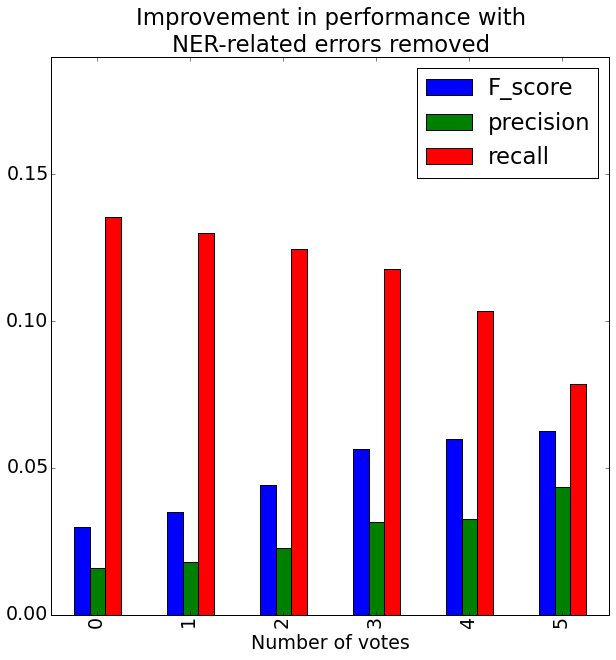

In [157]:


graph = temp.plot(kind = "bar", x = "threshold",
                 figsize = (10, 10),
                 title = "Improvement in performance with\nNER-related errors removed")
graph.set_ylim((0, 0.19))
graph.set_xlabel("Number of votes")
plt.savefig("data/improvement.png", bbox_inches = "tight")

In [125]:
no_ner_res - official_res_vote

,F_score,precision,recall,threshold
0,0.034888,0.018076,0.129976,0
1,0.044129,0.022587,0.124686,0
2,0.062655,0.043459,0.078590,0
3,0.056393,0.031677,0.117885,0
4,0.059771,0.032518,0.103527,0
5,0.029713,0.016010,0.135266,0


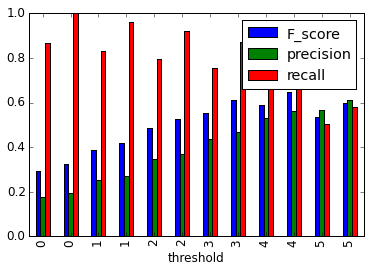

In [124]:
kek.sort("threshold").plot(kind = "bar", x = "threshold")

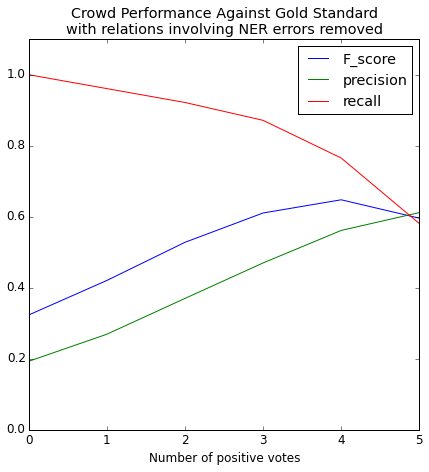

In [112]:
matplotlib.rcParams.update({'font.size': 12})
title = "Crowd Performance Against Gold Standard\nwith relations involving NER errors removed"

plot_it(no_ner_res, title, "Number of positive votes")

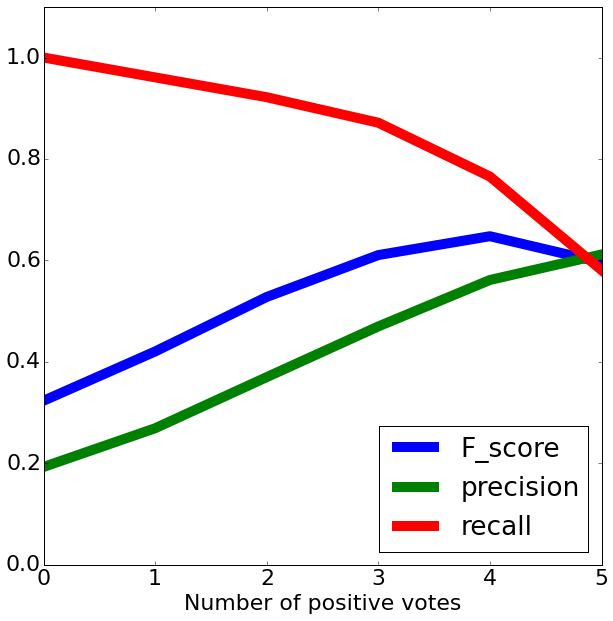

In [113]:
big_plot(no_ner_res, "", "Number of positive votes",
        22, (10, 10), "data/perf_no_ner.eps")

In [114]:
clean_res = single_fin_res.query("chem_in_gold and dise_in_gold")

NameError: name 'single_fin_res' is not defined

In [ ]:
clean_res.shape

In [ ]:
clean_res.head()

In [ ]:
clean_res["chem_in_gold"].value_counts()

In [ ]:
clean_res["dise_in_gold"].value_counts()

In [ ]:
no_ner_official_res = new_F_score("norm_conf_score", clean_res)

In [ ]:
no_ner_official_res_votes = new_F_score("num_votes", clean_res)

In [ ]:
no_ner_official_res_votes.sort("F_score", ascending = False)